<a href="https://colab.research.google.com/github/MahdiEsrafili/graph_theory/blob/master/bacterial_segmentaion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/MahdiEsrafili/SegLoss.git

Cloning into 'SegLoss'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 339 (delta 0), reused 3 (delta 0), pack-reused 334
Receiving objects: 100% (339/339), 375.41 KiB | 26.81 MiB/s, done.
Resolving deltas: 100% (157/157), done.


In [3]:
! pip install -q kaggle

In [4]:
! mkdir ~/.kaggle
% cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d longnguyen2306/bacteria-detection-with-darkfield-microscopy

 94% 153M/162M [00:00<00:00, 150MB/s]
100% 162M/162M [00:00<00:00, 185MB/s]


In [5]:
!unzip -q bacteria-detection-with-darkfield-microscopy.zip -d data/

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import numpy as np
import os
import random
from PIL import Image
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

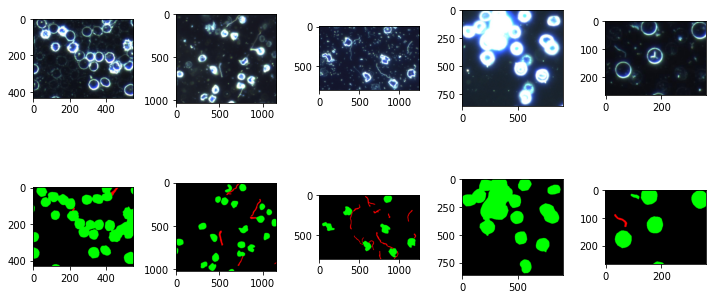

In [2]:
plt.figure(figsize=(10, 5))
idxs = np.random.randint(1, 366, size=5)
for n, i in enumerate(idxs):
  idx = '{:03}'.format(i)
  img = cv2.imread(f'data/images/{idx}.png')
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  mask = cv2.imread(f'data/masks/{idx}.png')
  mask[:,:,0] = np.where(mask[:,:,0]==2, 255, mask[:,:,0])
  mask[:,:,1] = np.where(mask[:,:,1]==1, 255, mask[:,:,1])
  plt.subplot(2, 5, n+1)
  plt.imshow(img)
  plt.subplot(2, 5, 5+n+1)
  plt.imshow(mask)

plt.tight_layout()

In [3]:
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as T
from torchvision import models
from tqdm.notebook import tqdm
import torchvision
import torch

In [4]:
img_dir = '/content/data/images'
files = os.listdir(img_dir)
random.shuffle(files)
train_test_ratio = 0.7
split_idx = int(len(files) * train_test_ratio)
train_id = files[:split_idx]
test_id = files[split_idx:]

In [5]:
# for f in files:
#   img = cv2.imread(f'/content/data/images/{f}')
#   print(img.shape)

In [6]:
train_id.__len__(), test_id.__len__()

(256, 110)

In [7]:
class BacterialDS(Dataset):
  def __init__(self, ids, path, transforms=None):
    self.ids = ids
    self.path = path
    self.transforms = transforms

  def __len__(self):
    return len(self.ids)

  def __getitem__(self, idx):
    img_path = os.path.join(self.path, 'images', self.ids[idx])
    mask_path = os.path.join(self.path, 'masks', self.ids[idx])
    img = Image.open(img_path)
    mask = Image.open(mask_path)
    if self.transforms:
      img = self.transforms['image'](img)
      mask = self.transforms['mask'](mask)
    mask = np.array(mask)[:,:,0]
    mask = torch.tensor(mask)
    return img, mask

In [27]:
img_transforms = T.Compose([
                        T.Resize((480, 480)),
                        T.ToTensor(),
                        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])                        
])
mask_transforms = T.Compose([
                        T.Resize((480, 480)),                 
])
transforms = {
    'image' : img_transforms,
    'mask' : mask_transforms
}

In [28]:
path = '/content/data'
train_dataset = BacterialDS(train_id, path, transforms)
test_dataset = BacterialDS(test_id, path, transforms)

batch_size = 4
train_loader = DataLoader(train_dataset, batch_size)
test_loader = DataLoader(test_dataset, batch_size)

In [31]:
model = models.segmentation.deeplabv3_resnet50(pretrained=True, progress=True)

In [32]:
model.classifier = models.segmentation.deeplabv3.DeepLabHead(2048, 3)

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [34]:
model = model.train().to(device)

In [35]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])
unnormalizer = UnNormalize(mean, std)

In [40]:
def train(model, optimizer, criterion, lr_scheduler, loaders, epochs=10):
  loss_history = []
  for epoch in range(epochs):
    model = model.train()
    pbar = tqdm(loaders['train_loader'])
    epoch_loss = np.array([])
    for images, labels in pbar:
      images = images.to(device).float()
      labels = labels.to(device).long()
      optimizer.zero_grad()
      out = model(images)
      loss = criterion(out['out'], labels)
      loss.backward()
      optimizer.step()
      epoch_loss = np.append(epoch_loss, loss.item())
      pbar.set_description(f'epoch {epoch+1}/{epochs}, loss= {epoch_loss.mean():.5f}')
    
    loss_history.append(epoch_loss.mean())
    lr_scheduler.step()
    with torch.no_grad():
      model.eval()
      test_samples = next(iter(loaders['test_loader']))
      out = model(test_samples[0].to(device).float())
      plt.figure(figsize=(15,5))
      plt.subplot(1,3,1)
      plt.imshow(unnormalizer(test_samples[0][0].cpu()).permute(1,2,0))
      plt.title('image')
      plt.subplot(1,3,2)
      plt.imshow(test_samples[1][0].cpu())
      plt.title('ground truth')
      plt.subplot(1,3,3)
      plt.imshow(out['out'][0].permute(1,2,0).cpu().argmax(dim=2))
      plt.title('predicted mask')
      plt.show()
  return model, loss_history

In [41]:
from SegLoss.losses_pytorch import lovasz_loss


In [42]:
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()
# criterion = lovasz_loss.LovaszSoftmax()
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [43]:
dataloaders = {'train_loader': train_loader,
               'test_loader': test_loader}

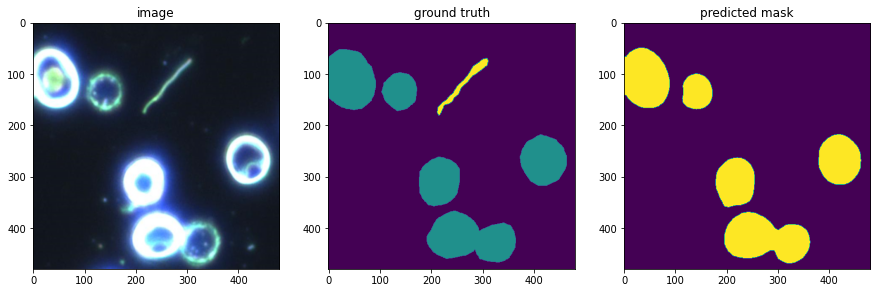

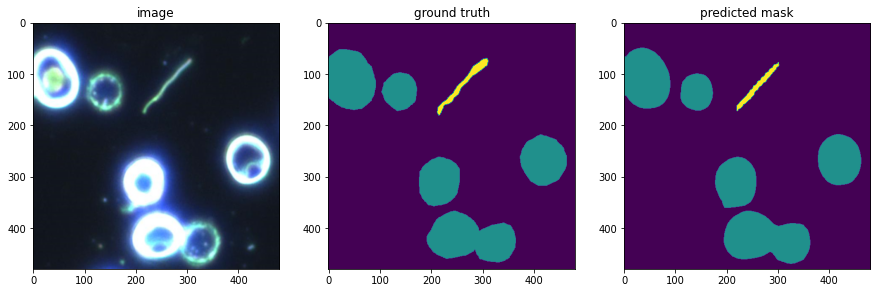

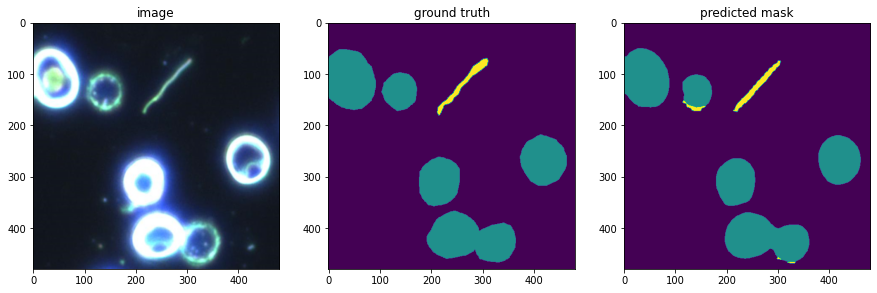

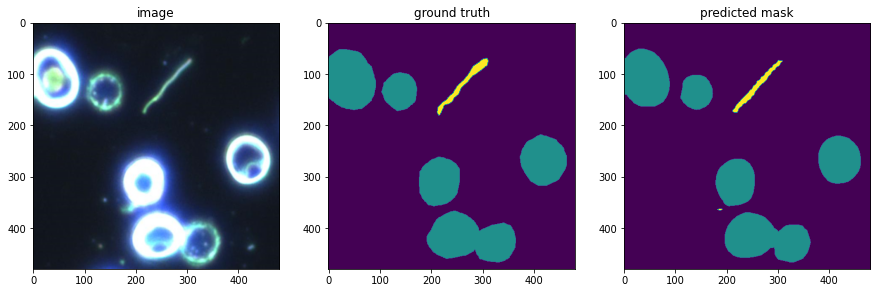

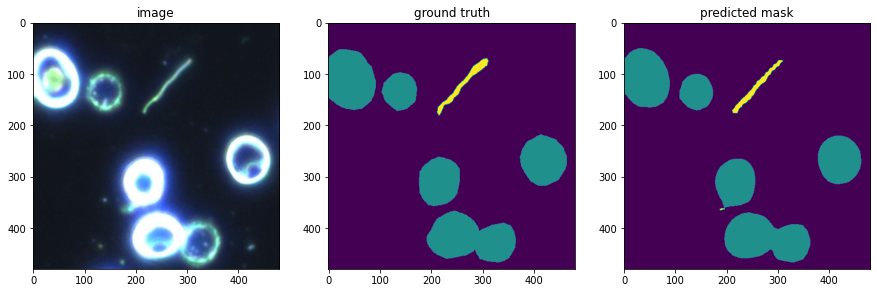

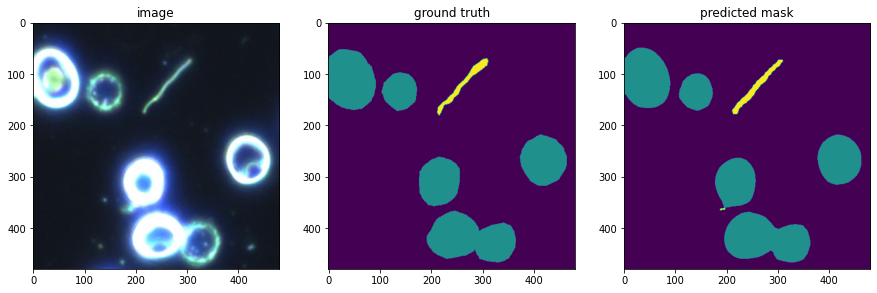

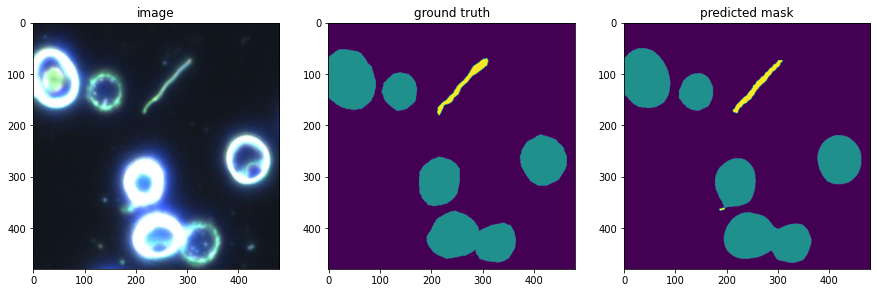

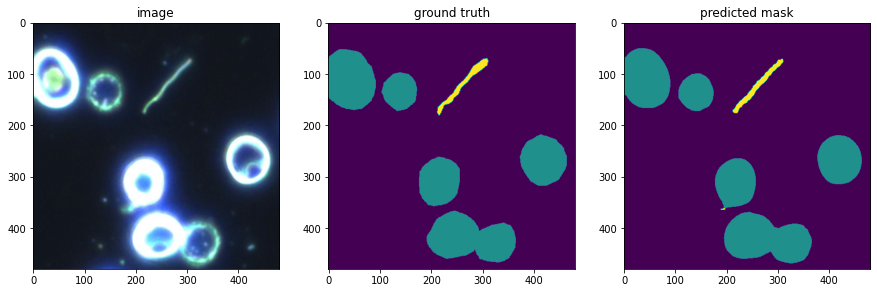

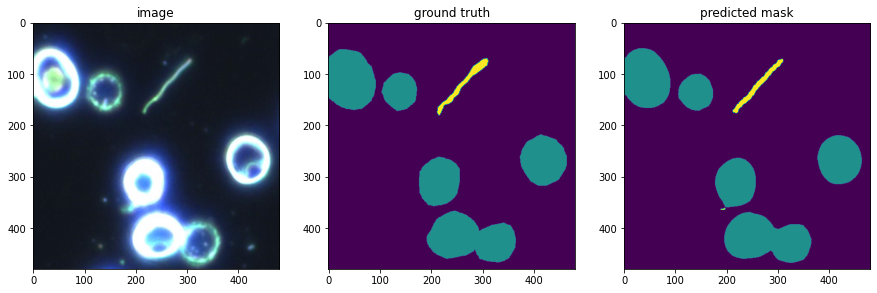

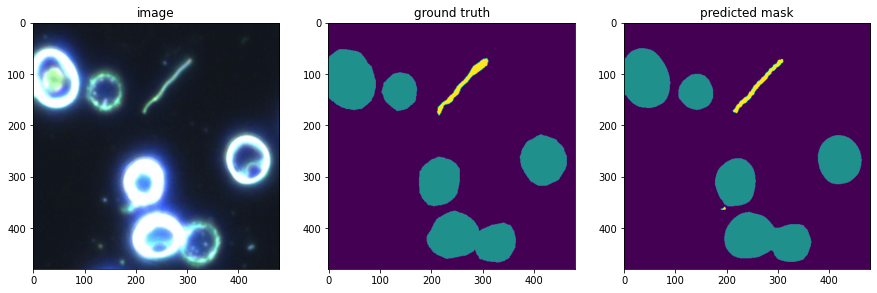

In [44]:
model, loss_history = train(model, optimizer, criterion, lr_scheduler, dataloaders)

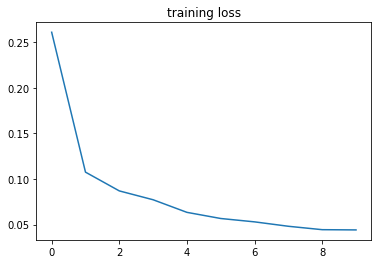

In [49]:
plt.plot(loss_history)
plt.title('training loss')
plt.show()

In [45]:
with open('/content/bacterial_semantic_model.pt', 'wb') as f:
  torch.save(model,f)

!cp /content/bacterial_semantic_model.pt /content/drive/MyDrive/bacterial_segmentation/

In [ ]:
!cp /content/drive/MyDrive/bacterial_segmentation/bacterial_semantic_model.pt /content/
model = torch.load('/content/bacterial_semantic_model.pt')

In [54]:
def test(model, dataloaders, criterion):
  with torch.no_grad():
    results = []
    ground_truth = []
    losses = np.array([])
    model.eval()
    for (images, masks) in dataloaders['test_loader']:
      images = images.to(device).float()
      masks = masks.to(device).long()
      preds = model(images)
      results.append(preds['out'].cpu())
      loss = criterion(preds['out'], masks)
      losses = np.append(losses, loss.item())
    
    print(f'test loss = {losses.mean():.5f}')
    return results, losses

In [55]:
results, losses = test(model, dataloaders, criterion)

test loss = 0.10544


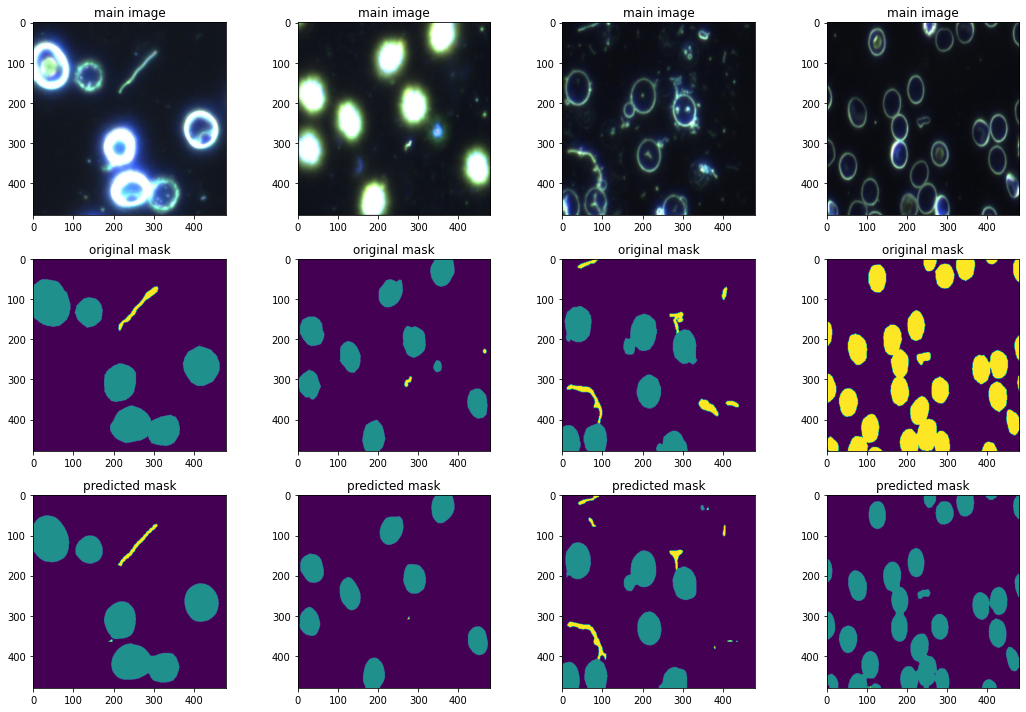

In [58]:
plt.figure(figsize=(15, 10))
test_img = iter(dataloaders['test_loader'])
for batches in results:
  grounds = next(test_img)
  for i, pred in enumerate(batches):
    plt.subplot(3, 4, i+1)
    plt.title('main image')
    plt.imshow(unnormalizer(grounds[0][i]).permute(1,2,0))
    plt.subplot(3, 4, 4+i+1)
    plt.title('original mask')
    plt.imshow(grounds[1][i])
    plt.subplot(3, 4, 8+i+1)
    plt.title('predicted mask')
    plt.imshow(pred.argmax(dim=0))
  break

plt.tight_layout()